## Install and import required modules

In [ ]:
!pip install wfdb

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import pandas as pd

from Modules.Data_Loader import *
from Modules.Feature_Extraction import *

# Data Extraction
#### Data is read and extracted from the database using the wfdb toolbox which is designed to read mimic iv data

In [3]:
database_name = 'mimic4wdb/0.1.0'
max_records_to_load = 100

#read data from database
records = load_Data(database_name, max_records_to_load)

# Data Preprocessing
#### 1. Records are filtered out to keep only those records that contain atleast one hour of aVR, ABP, Pleth and Resp signals
<br>

* It is assumed that the ECG, Blood Pressure and O2 waveform data is most essential for monitoring pateint condition hence these signals are chosen.
<br>

- Moreover, the time series will be split into buckets of 1 hour, hence all patient data which doesn't have atleast 1 hour of continous signals are filtered out

In [4]:
required_sigs = ['ABP', 'Pleth', 'II']
req_seg_duration = 60*60

matching_records = filter_Data(database_name, required_sigs, req_seg_duration, records)

A total of 47 records met the requirements:


In [4]:
#extract signals
abp = extract_Signal(matching_records, "ABP",5)

In [5]:
ecg = extract_Signal(matching_records, "II",30)

In [6]:
ppg = extract_Signal(matching_records, "Pleth",5)

#### 2. Remove NaNs

In [6]:
for patient in ecg:
    ecg[patient] = Remove_nan(np.array(ecg[patient]))

for patient in ppg:
    ppg[patient] = Remove_nan(np.array(ppg[patient]))

for patient in abp:
    abp[patient] = Remove_nan(np.array(abp[patient]))

#### 3. Remove noise using Butterworth filter

In [7]:
abp_filt = reduce_noise_butterworth(abp, fs = 62.475)
ecg_filt = reduce_noise_butterworth(ecg, fs = 62.475)
ppg_filt = reduce_noise_butterworth(ppg, fs= 62.475)

# PLOT Corrected Signals

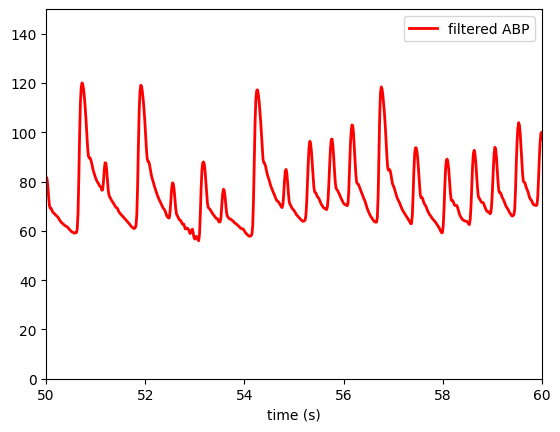

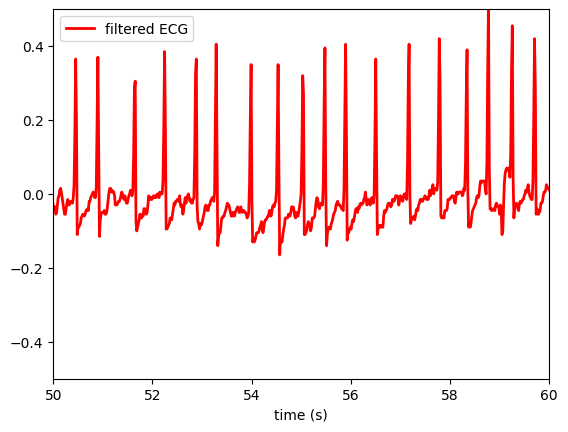

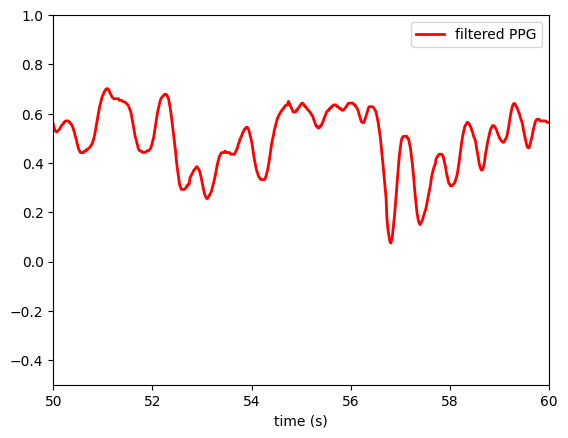

In [9]:
def Plot_signals(filtered_sig, label_original_sig, label_filtered_sig, ylim):
    fig, ax = plt.subplots()
    t = np.arange(0, len(filtered_sig))/62.475

    ax.plot(t, filtered_sig,
            linewidth=2.0,
            color = 'red',
            label = label_filtered_sig)

    ax.set(xlim=(0, 1000))
    plt.xlabel('time (s)')
    plt.xlim([50, 60])
    plt.ylim(ylim)
    plt.legend()
    plt.show()

Plot_signals(abp[list(abp_filt.keys())[0]], "original ABP", "filtered ABP", [0,150])
Plot_signals(ecg[list(ecg_filt.keys())[0]], "original ECG", "filtered ECG", [-0.5,0.5])
Plot_signals(ppg[list(ppg_filt.keys())[0]], "original PPG", "filtered PPG", [-0.5,1])

# Save Data to CSV

In [9]:
os.makedirs('Preprocessed_data/ppg', exist_ok=True)
os.makedirs('Preprocessed_data/abp', exist_ok=True)
os.makedirs('Preprocessed_data/ecg', exist_ok=True)

def write_to_csv(filepath, signals):
    for k in signals.keys():
        signals[k] = signals[k].tolist()
    with open(filepath, 'w') as f:
        f.write(json.dumps(signals))

write_to_csv('Preprocessed_data/abp/abp_unfiltered.txt', abp)
write_to_csv('Preprocessed_data/abp/abp_filtered.txt', abp_filt)

write_to_csv('Preprocessed_data/ecg/ecg_unfiltered.txt', ecg)
write_to_csv('Preprocessed_data/ecg/ecg_filtered.txt', ecg_filt)

write_to_csv('Preprocessed_data/ppg/ppg_unfiltered.txt', ppg)
write_to_csv('Preprocessed_data/ppg/ppg_filtered.txt', ppg_filt)